In [1]:
import numpy as np
import pandas as pd
import math
from functools import reduce
import random
random.seed(2010)

import matplotlib.pyplot as plt
%matplotlib inline

def cost_powers_k(rv, k = 2):
    assert(k!=1)
    if k == 2:
        cutoff = 1<<(int(rv)).bit_length()
    else:
        cutoff = k**(math.ceil(math.log(rv, k)))
    space_cost = cutoff-rv
    time_cost = (cutoff - 1)*1.0/(k-1)
    return (space_cost,time_cost,rv)

def sum_pair_costs(iterator, n,verbose = True):
    sum1,sum2,sum3 = reduce(lambda x,y : (x[0]+y[0],x[1]+y[1],x[2]+y[2]),\
                                        iterator,(0,0,0))
    return (sum1/n,sum2/n,sum3/n)

def cost_iterator(i,cost_func,my_list):
    for x in my_list:
        yield cost_func(x,i)
        
def MakeDiagram(data_location,list_of_funcs,range_for_x = np.linspace(1.02,3,97),
               title = "",x_label = "", y_label = "", line_parameters = [],additional_functions = []):
    val_array = []
    global global_observation_list
    n = 0
    mean = 1    
    with open(data_location,'r') as f:
        for line in f:
            v1,v2 = line.split(',')
            i = int(v2)
            a = int(v1)
            if a<1:
                continue
            n+=i
            mean+=i*a
            while (i>0):
                i-=1
                val_array.append(a)
    mean = mean/n
    assert(mean>1)    
    alpha = (2*mean-1)/(mean-1)
    print("alpha = {}".format(alpha))
    
    X = range_for_x
    list_Y = []
    for _ in range(len(list_of_funcs)):
        list_Y.append([])
    for i in X:
        global_observation_list = None
        for j in range(len(list_of_funcs)):
            list_Y[j].append(list_of_funcs[j](alpha,val_array,i))
    for func in additional_functions:
        func()            
    if len(list_Y) == len(line_parameters):
        for i in range(len(list_Y)):
            if line_parameters[i][0] is None:
                plt.plot(X,list_Y[i],label=line_parameters[i][1])
            else:
                plt.plot(X,list_Y[i],line_parameters[i][0],label=line_parameters[i][1],markevery = 10)
        plt.legend()
            
    else:        
        for Y in list_Y:
            plt.plot(X,Y)
    if title:
        plt.title(title, fontsize=14)
    if x_label:
        plt.xlabel(x_label, fontsize=12)
    if y_label:
        plt.ylabel(y_label, fontsize=12)
#plt.show()
#plt.savefig('results/ungraph_occupancy.png')    
    
    


In [14]:
def cost_powers_k(rv, k = 2):
    assert(k!=1)
    power = math.ceil(math.log(rv, k))
    cutoff = k**power
    space_cost = math.floor(cutoff)-rv
    #time_cost = sum_cutoff(k,power)
    time_cost = (cutoff - 1)*1.0/(k-1)
    return (space_cost,time_cost,rv)

def sum_cutoff(k,power):
    prev_V = 1
    prev_V_rounded = 1
    V = 1
    S = 0
    i = 1
    for i in range(power-1):
        V = math.floor(prev_V*k)
        print((V,S,i))        
        if prev_V_rounded == V:
            continue
        prev_V_rounded = V
        prev_V *= k
        S+=V
    print((V,S,i))            
    return S


def sum_pair_costs(iterator, n):
    sum1,sum2,sum3 = reduce(lambda x,y : (x[0]+y[0],x[1]+y[1],x[2]+y[2]),\
                                        iterator,(0,0,0))
    return (sum1/n,sum2/n,sum3/n)

global_observation_list = None
beta = .1
def memory_overhead(_, val_array, i):
    global global_observation_list    
    if global_observation_list is None:
        global_observation_list = sum_pair_costs(cost_iterator(i,cost_powers_k,val_array),len(val_array))
    return global_observation_list[0]
def computation_overhead (_, val_array, i):
    global global_observation_list
    if global_observation_list is None:
        global_observation_list = sum_pair_costs(cost_iterator(i,cost_powers_k,val_array),len(val_array))
    return global_observation_list[1]
def mean (_, val_array, i):
    global global_observation_list
    if global_observation_list is None:
        global_observation_list = sum_pair_costs(cost_iterator(i,cost_powers_k,val_array),len(val_array))
    return global_observation_list[2]
def occupancy (_, val_array, i):
    global global_observation_list
    if global_observation_list is None:
        global_observation_list = sum_pair_costs(cost_iterator(i,cost_powers_k,val_array),len(val_array))
    return global_observation_list[2]/(global_observation_list[0]+global_observation_list[2])
def cost ( _, val_array, i):
    global global_observation_list
    if global_observation_list is None:
        global_observation_list = sum_pair_costs(cost_iterator(i,cost_powers_k,val_array),len(val_array))
    return global_observation_list[0] + beta*global_observation_list[1]

estimated_occupancy = lambda a,_,i : ((1-a)/(2-a))*(1-(i-1)/(i-i**(2-a)))
estimated_memory = lambda a,_,i :  (i-1)/(1-i**(2-a)) + 1/(2-a)
estimated_mean = lambda a,_,i : (a-1)/(a-2)
estimated_computation = lambda a,_,i :  1/(1-i**(2-a))
estimated_cost = lambda a,_,i :  estimated_memory(a,_,i) + beta*estimated_computation(a,_,i)

cost_derivative = lambda a,b: lambda x : (\
                         1+(1-a)*x**(2-a)+(b*(2-a)-2+a)*(x)**(1-a)
                        )/((1-x**(2-a))**2)
reduced_cost_derivative = lambda a,b: lambda x : 1+(1-a)*x**(2-a)\
                                             +((b-1)*(2-a))*(x)**(1-a)

alpha = 2.0237927571316328


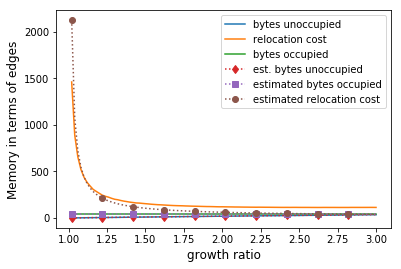

In [9]:
# data_location,list_of_funcs,range_for_x = np.linspace(1.02,3,100),
#               title = "",x_label = "", y_label = "", line_parameters = [],additional_functions = []
data_location = 'data/com-orkut.ungraphcounts.txt'
list_of_funcs =  [memory_overhead,computation_overhead,mean,estimated_memory,estimated_mean,estimated_computation]
title = "Orkut Memory Computation Trade Off"
x_label = 'growth ratio'
y_label = 'Memory in terms of edges'
LineParams  = [[None,'bytes unoccupied'],[None,'relocation cost'],[None,'bytes occupied'],
                    [':d','est. bytes unoccupied'],[':s','estimated bytes occupied'],[':o','estimated relocation cost']]
additional_functions = []; [lambda : plt.ylim(0,100)]
X = list(np.linspace(1.02,3,100))
MakeDiagram(data_location,list_of_funcs,range_for_x = X, x_label = x_label,\
            y_label = y_label, line_parameters = LineParams,additional_functions = additional_functions)
plt.show()

alpha = 2.066606331495111


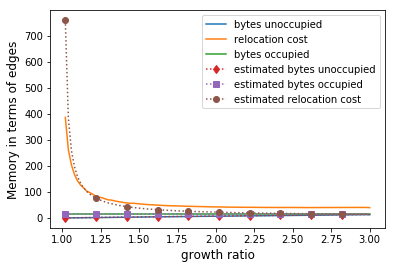

In [10]:
data_location = 'data/soc-LiveJournal1counts.txt'
list_of_funcs =  [memory_overhead,computation_overhead,mean,estimated_memory,estimated_mean,estimated_computation]
title = "LiveJournal Memory Computation Trade Off"
x_label = 'growth ratio'
y_label = 'Memory in terms of edges'
LineParams  = [[None,'bytes unoccupied'],[None,'relocation cost'],[None,'bytes occupied'],
                    [':d','estimated bytes unoccupied'],[':s','estimated bytes occupied'],[':o','estimated relocation cost']]
additional_functions = []#[lambda : plt.ylim(0,30)]
X = list(np.linspace(1.02,3,100))
MakeDiagram(data_location,list_of_funcs, range_for_x = X, x_label = x_label,\
            y_label = y_label, line_parameters = LineParams,additional_functions = additional_functions)
plt.show()

alpha = 2.066606331495111


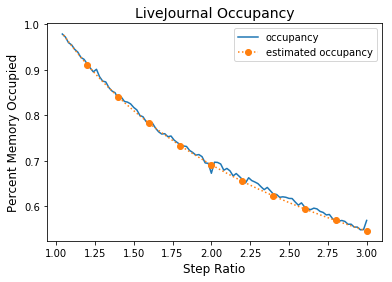

In [3]:
data_location = 'data/soc-LiveJournal1counts.txt'
list_of_funcs =  [occupancy,estimated_occupancy]
title = "LiveJournal Occupancy"
x_label = 'Step Ratio'
y_label = 'Percent Memory Occupied'
LineParams  = [[None,'occupancy'],[':o','estimated occupancy']]
additional_functions = []
x_range = []
for j in range(99):
    x_range.append(3-j*.02)
MakeDiagram(data_location,list_of_funcs, range_for_x=x_range, title = title, x_label = x_label,\
            y_label = y_label, line_parameters = LineParams,additional_functions = additional_functions)
plt.show()

alpha = 2.0237927571316328


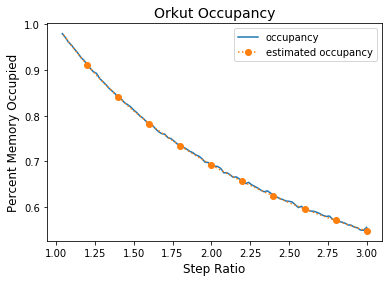

In [4]:
data_location = 'data/com-orkut.ungraphcounts.txt'
list_of_funcs =  [occupancy,estimated_occupancy]
title = "Orkut Occupancy"
x_label = 'Step Ratio'
y_label = 'Percent Memory Occupied'
LineParams  = [[None,'occupancy'],[':o','estimated occupancy']]
additional_functions = []
x_range = []
for j in range(99):
    x_range.append(3-j*.02)
MakeDiagram(data_location,list_of_funcs, range_for_x=x_range, title = title, x_label = x_label,\
            y_label = y_label, line_parameters = LineParams,additional_functions = additional_functions)
plt.show()

In [12]:
198/2

99.0

In [14]:
np.linspace(1.02,3,97)

array([1.02    , 1.040625, 1.06125 , 1.081875, 1.1025  , 1.123125,
       1.14375 , 1.164375, 1.185   , 1.205625, 1.22625 , 1.246875,
       1.2675  , 1.288125, 1.30875 , 1.329375, 1.35    , 1.370625,
       1.39125 , 1.411875, 1.4325  , 1.453125, 1.47375 , 1.494375,
       1.515   , 1.535625, 1.55625 , 1.576875, 1.5975  , 1.618125,
       1.63875 , 1.659375, 1.68    , 1.700625, 1.72125 , 1.741875,
       1.7625  , 1.783125, 1.80375 , 1.824375, 1.845   , 1.865625,
       1.88625 , 1.906875, 1.9275  , 1.948125, 1.96875 , 1.989375,
       2.01    , 2.030625, 2.05125 , 2.071875, 2.0925  , 2.113125,
       2.13375 , 2.154375, 2.175   , 2.195625, 2.21625 , 2.236875,
       2.2575  , 2.278125, 2.29875 , 2.319375, 2.34    , 2.360625,
       2.38125 , 2.401875, 2.4225  , 2.443125, 2.46375 , 2.484375,
       2.505   , 2.525625, 2.54625 , 2.566875, 2.5875  , 2.608125,
       2.62875 , 2.649375, 2.67    , 2.690625, 2.71125 , 2.731875,
       2.7525  , 2.773125, 2.79375 , 2.814375, 2.835   , 2.855

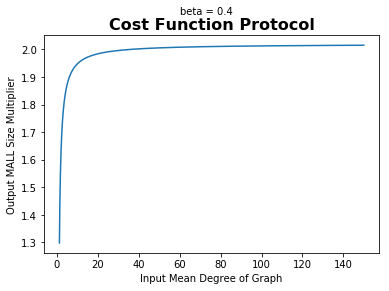

In [20]:
import math
from scipy.optimize import fsolve

reduced_cost_derivative = lambda a,b: lambda x : 1+(1-a)*x**(2-a)\
                                             +((b-1)*(2-a))*(x)**(1-a)
beta = .4
initial_guess = 1.5
Y = []
X = np.linspace(1.2,150,20000)
for m in X:
    alpha = (2*m-1)/(m-1) 
    result = fsolve(reduced_cost_derivative(alpha,beta), initial_guess)[0]
    Y.append(result)
plt.plot(X,Y)

alpha  = 2.0237927571316328
result = fsolve(reduced_cost_derivative(alpha,beta), initial_guess)[0]

plt.title("Cost Function Protocol", fontsize=16, fontweight='bold')
plt.suptitle("beta = {}".format(beta), fontsize=10)
plt.xlabel("Input Mean Degree of Graph")
plt.ylabel("Output MALL Size Multiplier")
plt.show()


In [24]:
power = 14
ratio = 1.25
sum_cutoff(ratio,power)
print((ratio**power-1)/(ratio-1))
s = 0

for i in range(power):
    print((ratio**i,s,i))
    s+=math.floor(ratio**i)
print(s)
    

(1, 1, 0)
(1, 1, 1)
(2, 1, 2)
(3, 3, 3)
(3, 6, 4)
(4, 6, 5)
(5, 10, 6)
(7, 15, 7)
(9, 22, 8)
(11, 31, 9)
(14, 42, 10)
(18, 56, 11)
(22, 74, 12)
(22, 96, 12)
86.94947017729282
(1.0, 0, 0)
(1.25, 1, 1)
(1.5625, 2, 2)
(1.953125, 3, 3)
(2.44140625, 4, 4)
(3.0517578125, 6, 5)
(3.814697265625, 9, 6)
(4.76837158203125, 12, 7)
(5.9604644775390625, 16, 8)
(7.450580596923828, 21, 9)
(9.313225746154785, 28, 10)
(11.641532182693481, 37, 11)
(14.551915228366852, 48, 12)
(18.189894035458565, 62, 13)
80
